In [1]:
import pandas as pd
from pathlib import Path
import tensorflow as tf
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt


2025-04-10 13:25:57.152883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744287957.216027   47325 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744287957.232501   47325 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744287957.303654   47325 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744287957.303697   47325 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744287957.303699   47325 computation_placer.cc:177] computation placer alr

In [2]:
def set_memory_growth():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

def set_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
        )

    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

set_memory_limit(4096)
#set_memory_growth()
tf.keras.mixed_precision.set_global_policy("mixed_float16")

pd.set_option('display.max_columns', None)

1 Physical GPU, 1 Logical GPUs


I0000 00:00:1744287965.221477   47325 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
df = Path("../histories").glob("mobilenetv2_1.00_224_filtered_multilabel*")
df = [pd.read_csv(csv) for csv in df] 
df = pd.concat(df)
df = df.drop_duplicates(["model", "epoch"], keep="last")
df

,binary_accuracy,f1_score_per_class,f1_score_weighted,loss,val_binary_accuracy,val_f1_score_per_class,val_f1_score_weighted,val_loss,model,epoch,type
0,0.939452,tf.Tensor(\n[0. 0.02298848 0.01503756 ...,0.326755,0.178081,0.968450,tf.Tensor(\n[0. 0. 0.08695652 ...,0.405542,0.106811,mobilenetv2_1.00_224_filtered_multilabel,0,CLF
1,0.970459,tf.Tensor(\n[0. 0. 0.14634144 ...,0.460955,0.097633,0.971706,tf.Tensor(\n[0. 0. 0.08695652 ...,0.490033,0.086371,mobilenetv2_1.00_224_filtered_multilabel,1,CLF
2,0.973165,tf.Tensor(\n[0. 0.01324503 0.31818175 ...,0.524442,0.082583,0.973643,tf.Tensor(\n[0. 0. 0.2222222 ...,0.535161,0.077014,mobilenetv2_1.00_224_filtered_multilabel,2,CLF
3,0.975028,tf.Tensor(\n[0. 0.01333333 0.45180717 ...,0.564923,0.073512,0.975349,tf.Tensor(\n[0. 0. 0.2222222 ...,0.570628,0.070680,mobilenetv2_1.00_224_filtered_multilabel,3,CLF
4,0.976348,tf.Tensor(\n[0. 0.04999998 0.48520705 ...,0.598324,0.067484,0.976357,tf.Tensor(\n[0. 0. 0.28571424 ...,0.595100,0.066293,mobilenetv2_1.00_224_filtered_multilabel,4,CLF
5,0.977705,tf.Tensor(\n[0. 0.10843372 0.52753615 ...,0.630182,0.062001,0.977442,tf.Tensor(\n[0. 0. 0.39999998 ...,0.615522,0.062788,mobilenetv2_1.00_224_filtered_multilabel,5,CLF
6,0.978549,tf.Tensor(\n[0. 0.18604647 0.55932194 ...,0.650010,0.058831,0.978295,tf.Tensor(\n[0. 0.07692306 0.45161283 ...,0.632189,0.060363,mobilenetv2_1.00_224_filtered_multilabel,6,CLF
7,0.979548,tf.Tensor(\n[0. 0.30337074 0.57617724 ...,0.674393,0.054940,0.978837,tf.Tensor(\n[0. 0.14814812 0.51612896 ...,0.644653,0.058310,mobilenetv2_1.00_224_filtered_multilabel,7,CLF
8,0.980120,tf.Tensor(\n[0. 0.31521735 0.6239999 ...,0.690645,0.052350,0.978992,tf.Tensor(\n[0. 0.21428569 0.5454545 ...,0.653462,0.056387,mobilenetv2_1.00_224_filtered_multilabel,8,CLF
9,0.980974,tf.Tensor(\n[0. 0.29189187 0.60752684 ...,0.707402,0.050046,0.980000,tf.Tensor(\n[0. 0.2222222 0.6285714 ...,0.673565,0.054920,mobilenetv2_1.00_224_filtered_multilabel,9,CLF


# Dataset

In [4]:
image_dir = "/home/ruairi/.cache/kagglehub/datasets/bloox2/fieldplant/versions/1/train/"

In [5]:
def decode_img(filename, img_size):
    filepath = str(image_dir) + filename
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img

def process_dataset(img, label):
    img = decode_img(img, (224,224))
    return img, label

In [6]:
df = pd.read_csv("../data/filtered.csv")

X = df.filename.to_frame().to_numpy()
y = df.drop(columns=["filename"]).to_numpy()

X_train, y_train, X_test_val, y_test_val = iterative_train_test_split(X, y, test_size=0.2)
X_test, y_test, X_val, y_val = iterative_train_test_split(X_test_val, y_test_val, test_size=0.5)

train = pd.DataFrame(np.hstack([X_train, y_train]))
val = pd.DataFrame(np.hstack([X_val, y_val]))
test = pd.DataFrame(np.hstack([X_test, y_test]))

train.columns = df.columns
test.columns = df.columns
val.columns = df.columns


In [7]:
BATCH_SIZE=32
epochs = 100
num_classes = len(df.columns[1:])

In [8]:
X_train = train["filename"].values.astype(str)
y_train = train.drop(columns="filename").values.astype("float32")
X_test = test["filename"].values.astype(str)
y_test = test.drop(columns="filename").values.astype("float32")
X_val = val["filename"].values.astype(str)
y_val = val.drop(columns="filename").values.astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.map(lambda img, label: process_dataset(img, label)).shuffle(buffer_size=train_ds.cardinality()).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda img, label: process_dataset(img, label)).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda img, label: process_dataset(img, label)).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)



# Model

In [9]:
preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocessing(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics = [
        "binary_accuracy",
        tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)
    ]
)

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="../saved_models/final_mn.keras", save_best_only=True, monitor="val_loss", verbose=1)
]

model.summary(show_trainable=True, expand_nested=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand         │ (None, 112, 112, 96)  │      1,536 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_BN      │ (None, 112, 112, 96)  │        384 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_relu    │ (None, 112, 112, 96)  │          0 │   -   │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_pad            │ (None, 113, 113, 96)  │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │     

 Total params: 2,290,009 (8.74 MB)

 Trainable params: 32,025 (125.10 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs, callbacks=cbs)
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df['type'] = "CLF"

Epoch 1/100


2025-04-10 13:26:20.838820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 3066 of 4125
2025-04-10 13:26:25.617041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1744287985.672579   47412 service.cc:152] XLA service 0x7fa054110750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744287985.672677   47412 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-10 13:26:25.813961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744287986.477610   47412 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/129 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - binary_accuracy: 0.5934 - f1_score_per_class: 0.0692 - f1_score_weighted: 0.2395 - loss: 0.7744

I0000 00:00:1744287994.722673   47412 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.9150 - f1_score_per_class: 0.0747 - f1_score_weighted: 0.2800 - loss: 0.2221

2025-04-10 13:26:47.760826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1367', 224 bytes spill stores, 224 bytes spill loads

2025-04-10 13:26:47.925347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1367', 332 bytes spill stores, 332 bytes spill loads

2025-04-10 13:26:48.002083: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1367', 680 bytes spill stores, 684 bytes spill loads




Epoch 1: val_loss improved from inf to 0.08671, saving model to ../saved_models/final_mn.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - binary_accuracy: 0.9153 - f1_score_per_class: 0.0748 - f1_score_weighted: 0.2807 - loss: 0.2215 - val_binary_accuracy: 0.9704 - val_f1_score_per_class: 0.1154 - val_f1_score_weighted: 0.4718 - val_loss: 0.0867
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.9718 - f1_score_per_class: 0.1775 - f1_score_weighted: 0.5361 - loss: 0.0846
Epoch 2: val_loss improved from 0.08671 to 0.07274, saving model to ../saved_models/final_mn.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - binary_accuracy: 0.9718 - f1_score_per_class: 0.1777 - f1_score_weighted: 0.5363 - loss: 0.0846 - val_binary_accuracy: 0.9732 - val_f1_score_per_class: 0.1516 - val_f1_score_weighted: 0.5326 - val_loss: 0.0727
Epoch 3/100
127/129 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.9751 - f1_score_per_class: 0.2556 - f1_score_weighted: 0.6121 - loss

### Finetuning

In [11]:
best_epoch = history_df.iloc[history_df.val_loss.idxmin()]
best_val_loss = best_epoch.val_loss
best_val_loss

np.float64(0.05347195640206337)

In [12]:
base_model = model.get_layer(name="mobilenetv2_1.00_224")
freeze_layer = base_model.get_layer(name="block_16_expand")
freeze_num = 0
for i, layer in enumerate(base_model.layers):
    if layer == freeze_layer:
        freeze_num = i

In [13]:
for layer in base_model.layers[:freeze_num]:
    layer.trainable = False
for layer in base_model.layers[freeze_num:]:
    layer.trainable = True

lr = model.get_compile_config()['optimizer']['config']['learning_rate'] / 10

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics = [
        "binary_accuracy",
        tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)
    ]
)

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1, baseline=best_val_loss),
    tf.keras.callbacks.ModelCheckpoint(filepath="../saved_models/final_mn.keras", save_best_only=True, monitor="val_loss", verbose=1, initial_value_threshold=best_val_loss)
]

model.summary(show_trainable=True, expand_nested=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand         │ (None, 112, 112, 96)  │      1,536 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_BN      │ (None, 112, 112, 96)  │        384 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_relu    │ (None, 112, 112, 96)  │          0 │   -   │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_pad            │ (None, 113, 113, 96)  │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │     

 Total params: 2,290,009 (8.74 MB)

 Trainable params: 918,105 (3.50 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

In [14]:
history_ft = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs, callbacks=cbs, initial_epoch=best_epoch.epoch+1)

hist_ft_df = pd.DataFrame(history_ft.history)
hist_ft_df['epoch'] = history_ft.epoch
hist_ft_df['type'] = "FT"

Epoch 16/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - binary_accuracy: 0.9782 - f1_score_per_class: 0.5443 - f1_score_weighted: 0.7108 - loss: 0.0583
Epoch 16: val_loss did not improve from 0.05347
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - binary_accuracy: 0.9782 - f1_score_per_class: 0.5448 - f1_score_weighted: 0.7110 - loss: 0.0582 - val_binary_accuracy: 0.9752 - val_f1_score_per_class: 0.4007 - val_f1_score_weighted: 0.6798 - val_loss: 0.0894
Epoch 17/100
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.9866 - f1_score_per_class: 0.7191 - f1_score_weighted: 0.8277 - loss: 0.0353
Epoch 17: val_loss did not improve from 0.05347
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.9866 - f1_score_per_class: 0.7192 - f1_score_weighted: 0.8277 - loss: 0.0353 - val_binary_accuracy: 0.9762 - val_f1_score_per_class: 0.4148 - val_f1_score_weighted: 0.6974 - val_loss: 0.0853
Epoch 18/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.9891 - f1_sco

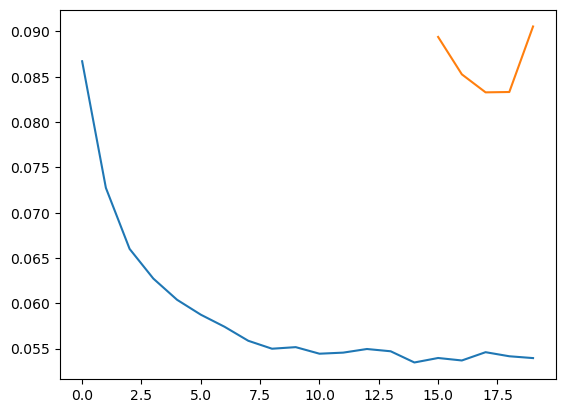

In [15]:
hist_df = pd.concat([history_df, hist_ft_df])
hist_df = hist_df.drop_duplicates(subset=["epoch"], keep="last")

plt.plot(history_df.epoch, history_df.val_loss)
plt.plot(hist_ft_df.epoch, hist_ft_df.val_loss)

# Hyperparameter Tuning

In [16]:
def call_existing_code(units, dropout_rate):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=base_model.input_shape[1:])
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    if units != 0:
        x = tf.keras.layers.Dense(units=units, use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

        
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid", name="clasifier")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer= tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["binary_accuracy",
                 tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
                 tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)]
        )
    return model

def build_model(hp):
    units = hp.Choice("units", [0, 256, 512])
    dropout_rate = hp.Choice("dropout", [0.2, 0.5])

    model = call_existing_code(
        units=units, dropout_rate=dropout_rate
    )
    return model

In [17]:
tuner = kt.RandomSearch(
    hypermodel= build_model,
    objective = kt.Objective("val_loss", "min"),
    directory="../hyperparameterTuning/",
    project_name="mobilenet_HT",
    overwrite=False,
    max_trials=40,
    seed=1
)
tuner.search_space_summary()

Reloading Tuner from ../hyperparameterTuning/mobilenet_HT/tuner0.json
Search space summary
Default search space size: 2
units (Choice)
{'default': 0, 'conditions': [], 'values': [0, 256, 512], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.5], 'ordered': True}


In [18]:
cbs = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]

tuner.search(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, verbose=1)

In [19]:
tuner.results_summary(32)

Results summary
Results in ../hyperparameterTuning/mobilenet_HT
Showing 32 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
units: 512
dropout: 0.5
Score: 0.041923850774765015

Trial 04 summary
Hyperparameters:
units: 512
dropout: 0.2
Score: 0.04193737357854843

Trial 02 summary
Hyperparameters:
units: 256
dropout: 0.5
Score: 0.04215090721845627

Trial 03 summary
Hyperparameters:
units: 256
dropout: 0.2
Score: 0.043105870485305786

Trial 01 summary
Hyperparameters:
units: 0
dropout: 0.2
Score: 0.0490000955760479

Trial 00 summary
Hyperparameters:
units: 0
dropout: 0.5
Score: 0.050420813262462616


In [20]:
units = 512
dropout_rate = 0.5

preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocessing(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=units, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics = [
        "binary_accuracy",
        tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)
    ]
)

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="../saved_models/mn_HT.keras", save_best_only=True, monitor="val_loss", verbose=1)
]

model.summary(show_trainable=True, expand_nested=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide_1 (TrueDivide)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract_1 (Subtract)       │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand         │ (None, 112, 112, 96)  │      1,536 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_BN      │ (None, 112, 112, 96)  │        384 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_relu    │ (None, 112, 112, 96)  │          0 │   -   │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_pad            │ (None, 113, 113, 96)  │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │     

 Total params: 2,928,217 (11.17 MB)

 Trainable params: 669,209 (2.55 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [22]:
history_final = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs, callbacks=cbs)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - binary_accuracy: 0.9914 - f1_score_per_class: 0.7961 - f1_score_weighted: 0.8892 - loss: 0.0215
Epoch 1: val_loss did not improve from 0.04546
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - binary_accuracy: 0.9914 - f1_score_per_class: 0.7964 - f1_score_weighted: 0.8892 - loss: 0.0215 - val_binary_accuracy: 0.9831 - val_f1_score_per_class: 0.5368 - val_f1_score_weighted: 0.7780 - val_loss: 0.0477
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.9923 - f1_score_per_class: 0.8194 - f1_score_weighted: 0.9025 - loss: 0.0197
Epoch 2: val_loss did not improve from 0.04546
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_accuracy: 0.9923 - f1_score_per_class: 0.8196 - f1_score_weighted: 0.9025 - loss: 0.0197 - val_binary_accuracy: 0.9834 - val_f1_score_per_class: 0.6095 - val_f1_score_weighted: 0.7787 - val_loss: 0.0478
Epoch 3/100
127/129 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.9929 - f1_score_

In [24]:
history_final_df = pd.DataFrame(history_final.history)
history_final_df['epoch'] = history_final.epoch
history_final_df['type'] = "CLF"

In [25]:
best_epoch = history_df.iloc[history_df.val_loss.idxmin()]
best_val_loss = best_epoch.val_loss
best_val_loss

base_model = model.get_layer(name="mobilenetv2_1.00_224")
freeze_layer = base_model.get_layer(name="block_16_expand")
freeze_num = 0
for i, layer in enumerate(base_model.layers):
    if layer == freeze_layer:
        freeze_num = i
        
for layer in base_model.layers[:freeze_num]:
    layer.trainable = False
for layer in base_model.layers[freeze_num:]:
    layer.trainable = True

lr = model.get_compile_config()['optimizer']['config']['learning_rate'] / 10

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics = [
        "binary_accuracy",
        tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)
    ]
)

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1, baseline=best_val_loss),
    tf.keras.callbacks.ModelCheckpoint(filepath="../saved_models/mn_HT.keras", save_best_only=True, monitor="val_loss", verbose=1, initial_value_threshold=best_val_loss)
]

model.summary(show_trainable=True, expand_nested=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide_1 (TrueDivide)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract_1 (Subtract)       │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand         │ (None, 112, 112, 96)  │      1,536 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_BN      │ (None, 112, 112, 96)  │        384 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_relu    │ (None, 112, 112, 96)  │          0 │   -   │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_pad            │ (None, 113, 113, 96)  │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │     

 Total params: 2,928,217 (11.17 MB)

 Trainable params: 1,555,289 (5.93 MB)

 Non-trainable params: 1,372,928 (5.24 MB)

In [26]:
history_ft_final = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs, callbacks=cbs, initial_epoch=best_epoch.epoch+1)

Epoch 16/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - binary_accuracy: 0.9851 - f1_score_per_class: 0.6034 - f1_score_weighted: 0.7981 - loss: 0.0400
Epoch 16: val_loss did not improve from 0.05347
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - binary_accuracy: 0.9852 - f1_score_per_class: 0.6039 - f1_score_weighted: 0.7983 - loss: 0.0400 - val_binary_accuracy: 0.9810 - val_f1_score_per_class: 0.4788 - val_f1_score_weighted: 0.7530 - val_loss: 0.0747
Epoch 17/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.9930 - f1_score_per_class: 0.8334 - f1_score_weighted: 0.9134 - loss: 0.0192
Epoch 17: val_loss did not improve from 0.05347
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - binary_accuracy: 0.9930 - f1_score_per_class: 0.8334 - f1_score_weighted: 0.9134 - loss: 0.0192 - val_binary_accuracy: 0.9798 - val_f1_score_per_class: 0.4819 - val_f1_score_weighted: 0.7473 - val_loss: 0.0911
Epoch 18/100
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.9953 - f1_sco

In [28]:
history_ft_final_df = pd.DataFrame(history_ft_final.history)
history_ft_final_df['epoch'] = history_ft_final.epoch
history_ft_final_df['type'] = "FT"